### Thông tin về bộ dữ liệu IMDB

Dữ liệu IMDB là bộ dữ liệu chứa 50.000 đánh giá phim để xử lý ngôn ngữ tự nhiên, tức là để phân loại cảm xúc nhị phân. Dữ liệu này có hai cột - đánh giá và cảm xúc để thực hiện phân tích cảm xúc.

### Overview
Trong notebook này, chúng em thực hiện làm sạch dữ liệu, phân tích dữ liệu khám phá và mô hình dự đoán bằng cách sử dụng các thuật toán học máy. Đối với học máy, nhóm chúng em sử dụng Hồi quy Logistic, Multinomial Naive Bayes, Linear SVM và XGBoost.
Đối với học sâu, chúng em sử dụng kết hợp CNN+LSTM và BERT. Độ chính xác cao nhất đạt được khi sử dụng BERT là khoảng 90%.

### References
Một số nguồn tài liệu nhóm chúng em đã sử dụng để tham khảo:
1. https://www.kaggle.com/madz2000/sentiment-analysis-cleaning-eda-bert-88-acc/output
2. https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2
3. https://www.kaggle.com/faressayah/sentiment-model-with-tensorflow-transformers
4. https://www.kaggle.com/sravyaysk/imdb-movie-review-classification-using-tensorflow
5. https://www.kaggle.com/colearninglounge/nlp-data-preprocessing-and-cleaning
6. https://huggingface.co/transformers/master/custom_datasets.html


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# **1. Importing Libraries**

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from xgboost.sklearn import XGBClassifier



# **2. Data Extraction and Cleaning (Trích xuất và làm sạch dữ liệu)**

* 2.1 Đọc và in ra bộ dữ liệu

In [4]:
data=pd.read_csv('IMDBDataset.csv')
data.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

* 2.2 Thống kê mô tả dữ liệu

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


-> Bộ dữ liệu gồm có 50.000 dòng , 2 cột bao gồm các đánh giá  

In [6]:
data.describe() #descriptive statistics

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

+ Xác định các giá trị bị thiếu

In [7]:
null_values = data.isnull().sum()

In [8]:
null_values.index[0]

'review'

In [9]:
print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))

There are 0 missing values for review and 0 missing values for sentiment.


In [10]:
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [11]:
#view duplicate reviews
review = data['review']
duplicated_review = data[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

review sentiment
34058  "Go Fish" garnered Rose Troche rightly or wron...  negative
47467  "Go Fish" garnered Rose Troche rightly or wron...  negative
29956  "Three" is a seriously dumb shipwreck movie. M...  negative
31488  "Three" is a seriously dumb shipwreck movie. M...  negative
47527  "Witchery" might just be the most incoherent a...  negative

In [12]:
#drop duplicate reviews
data.drop_duplicates(inplace = True)

In [13]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(data.shape[0],data.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates


In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinhl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()

In [16]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

In [17]:
#Hàm sử dụng để clean data
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()])
    return text

In [18]:
data_copy = data.copy()

In [19]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vinhl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
data['review']=data['review'].apply(clean_text,lemmatize = True)

C:\Users\vinhl\AppData\Local\Temp\ipykernel_11172\1974210440.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") #remove html tags


In [21]:
#converting target variable to numeric labels
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [22]:
#after converting labels
data.head()

review  sentiment
0  one reviewer mentioned watching oz episode hoo...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  basically family little boy jake think zombie ...          0
4  petter matteis love time money visually stunni...          1

# **3. Exploratory data analysis**

In [23]:
### Count Plot
"""sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(data.sentiment,palette = ['green','red'],order = [1,0])
plt.xticks(ticks = np.arange(2),labels = ['Tích cực','Tiêu cực'])
plt.title('Target count for IMBD reviews')
plt.show()"""

'sns.set(style = "whitegrid" , font_scale = 1.2)\nsns.countplot(data.sentiment,palette = [\'green\',\'red\'],order = [1,0])\nplt.xticks(ticks = np.arange(2),labels = [\'Tích cực\',\'Tiêu cực\'])\nplt.title(\'Target count for IMBD reviews\')\nplt.show()'

In [24]:
print('Positive reviews are', (round(data['sentiment'].value_counts()[0])),'i.e.', round(data['sentiment'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Negative reviews are', (round(data['sentiment'].value_counts()[1])),'i.e.',round(data['sentiment'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

Positive reviews are 24698 i.e. 49.81 % of the dataset
Negative reviews are 24884 i.e. 50.19 % of the dataset


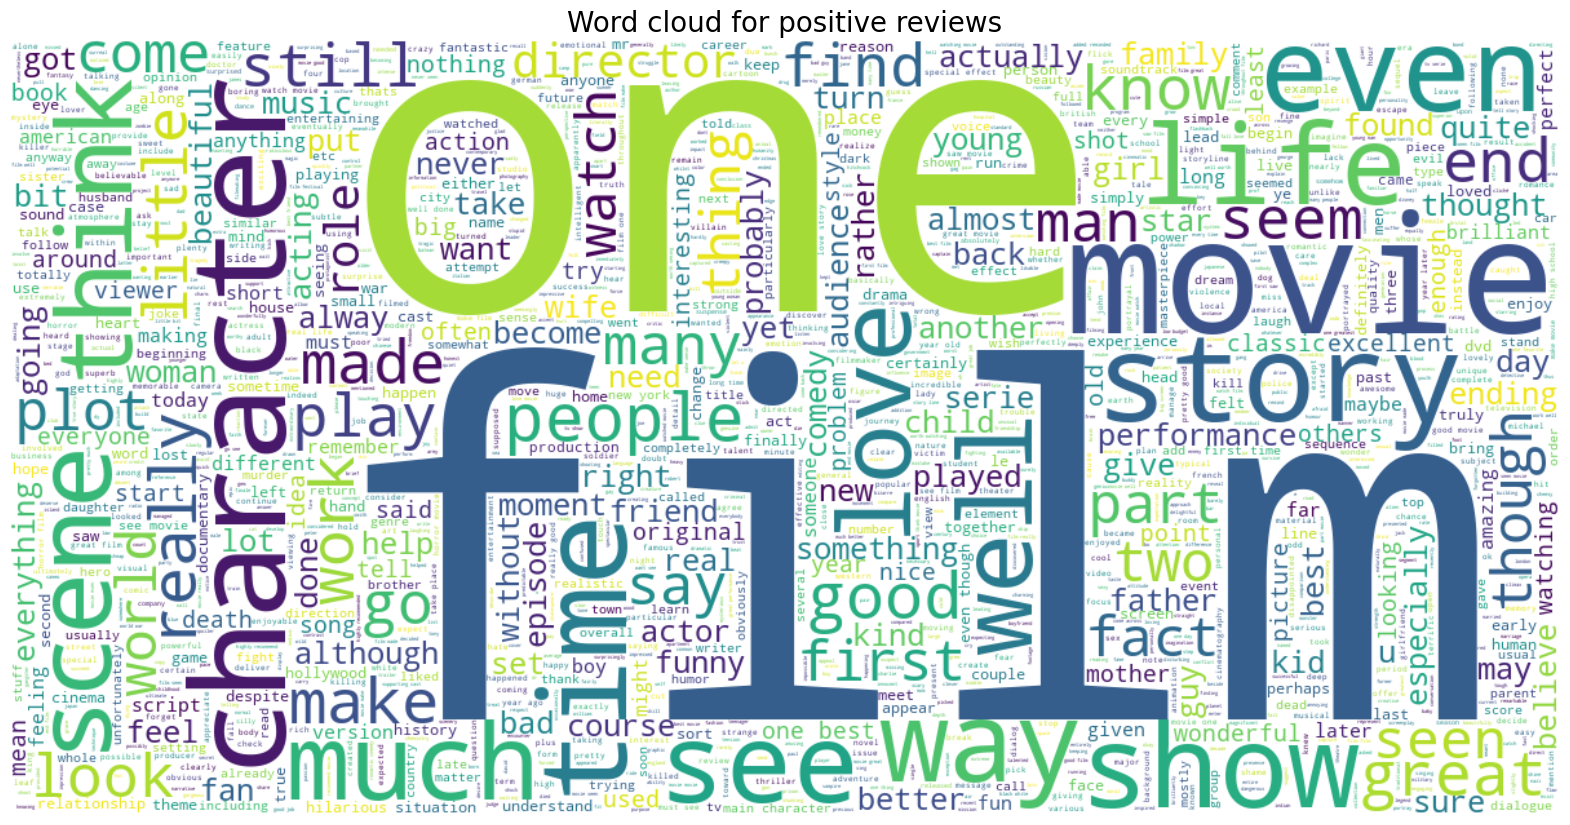

In [25]:
#word cloud cho các đánh giá tiêu cực
positive_data = data[data.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()

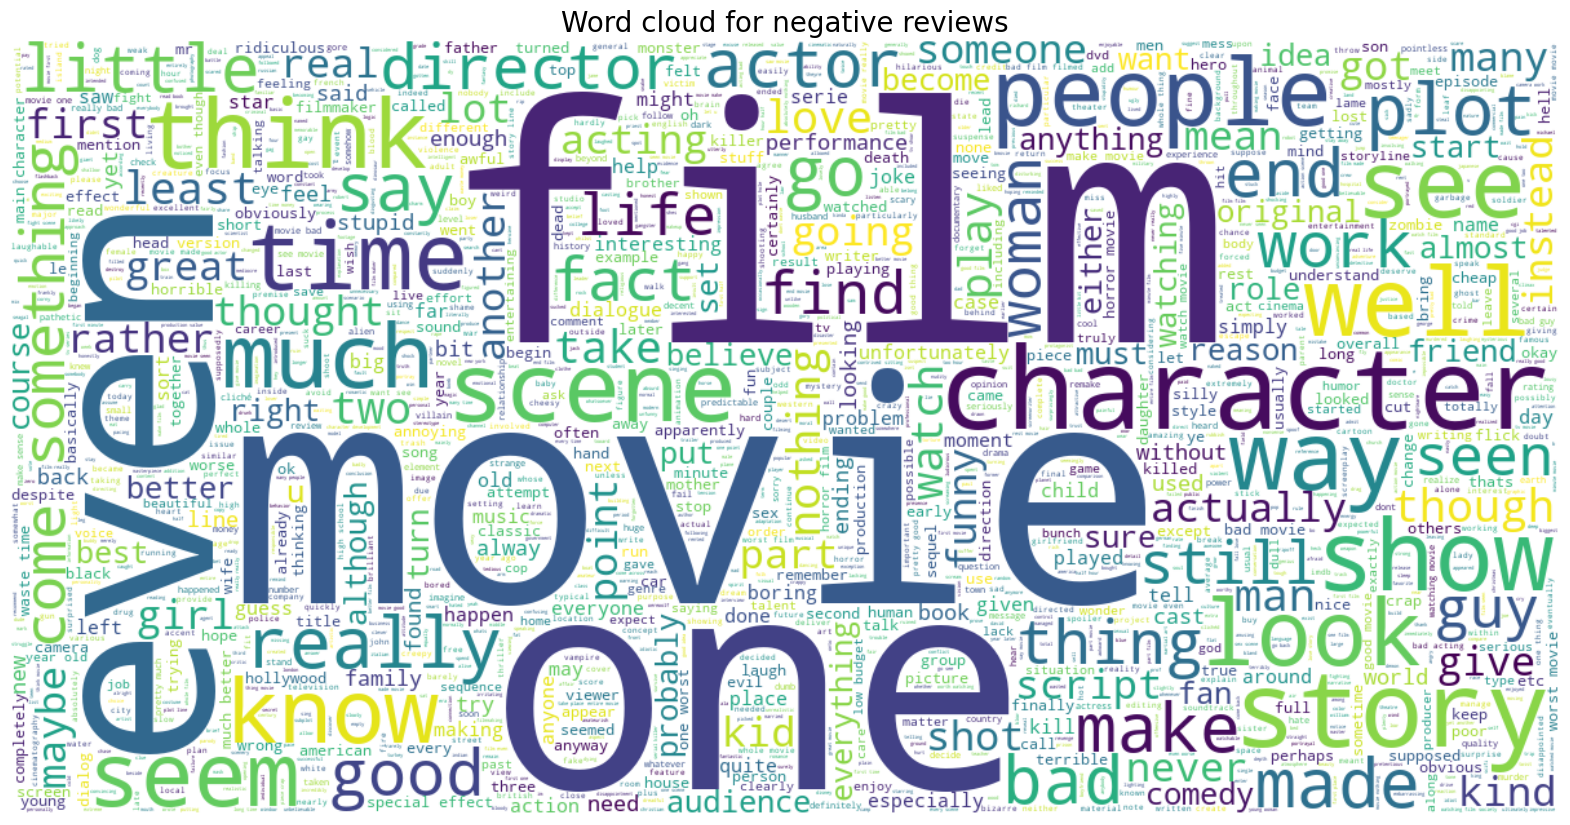

In [26]:
#word cloud cho các đánh giá tích cực
negative_data = data[data.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

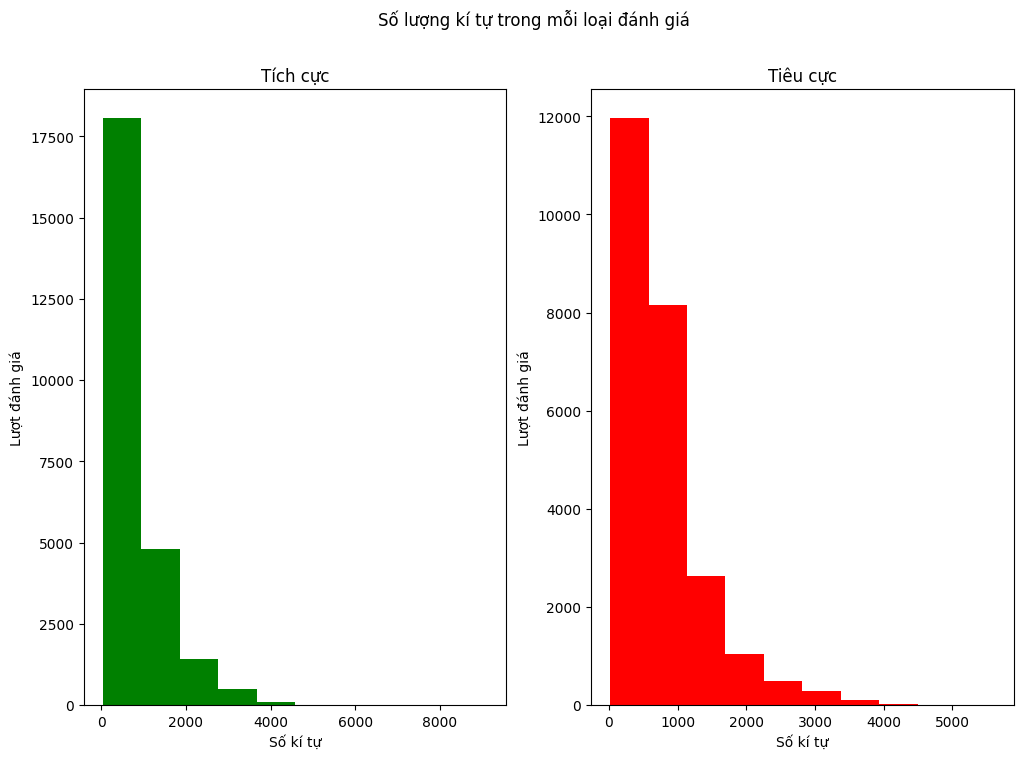

In [27]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Tích cực')
ax1.set_xlabel('Số kí tự')
ax1.set_ylabel('Lượt đánh giá')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Tiêu cực')
ax2.set_xlabel('Số kí tự')
ax2.set_ylabel('Lượt đánh giá')
fig.suptitle('Số lượng kí tự trong mỗi loại đánh giá')
plt.show()

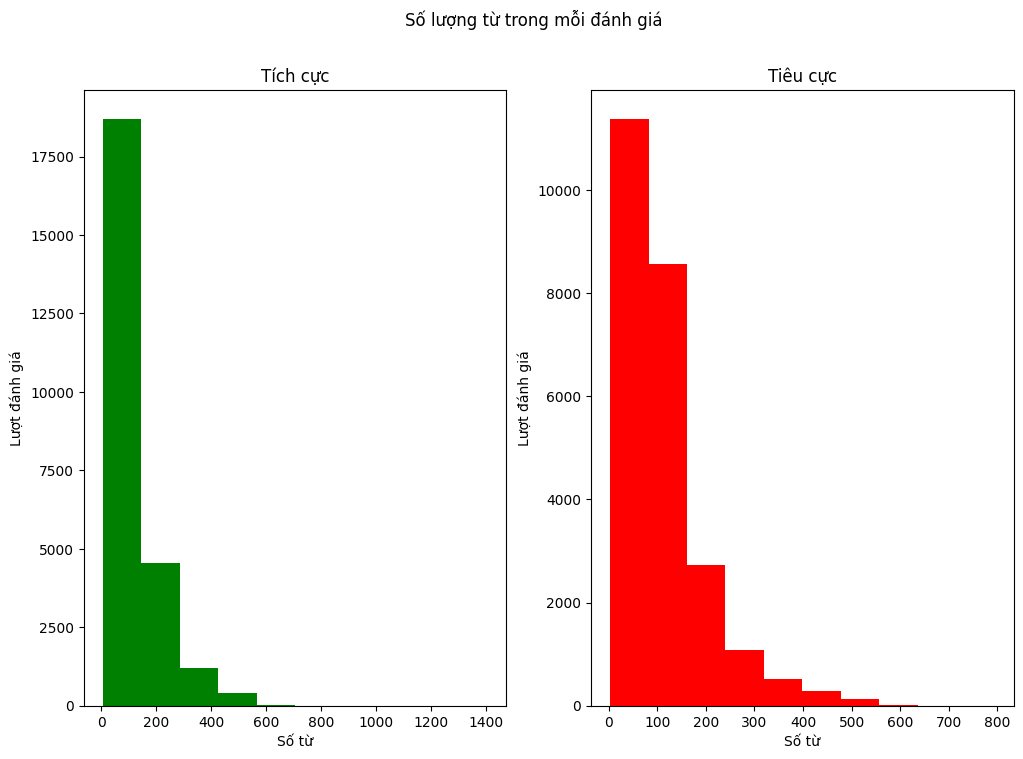

In [28]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Tích cực')
ax1.set_xlabel('Số từ')
ax1.set_ylabel('Lượt đánh giá')

text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Tiêu cực')
ax2.set_xlabel('Số từ')
ax2.set_ylabel('Lượt đánh giá')

fig.suptitle('Số lượng từ trong mỗi đánh giá')
plt.show()

C:\Users\vinhl\AppData\Local\Temp\ipykernel_11172\3932708398.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word, ax=ax1,color='green')
C:\Users\vinhl\AppData\Local\Temp\ipykernel_11172\3932708398.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,ax=ax2,color='red')


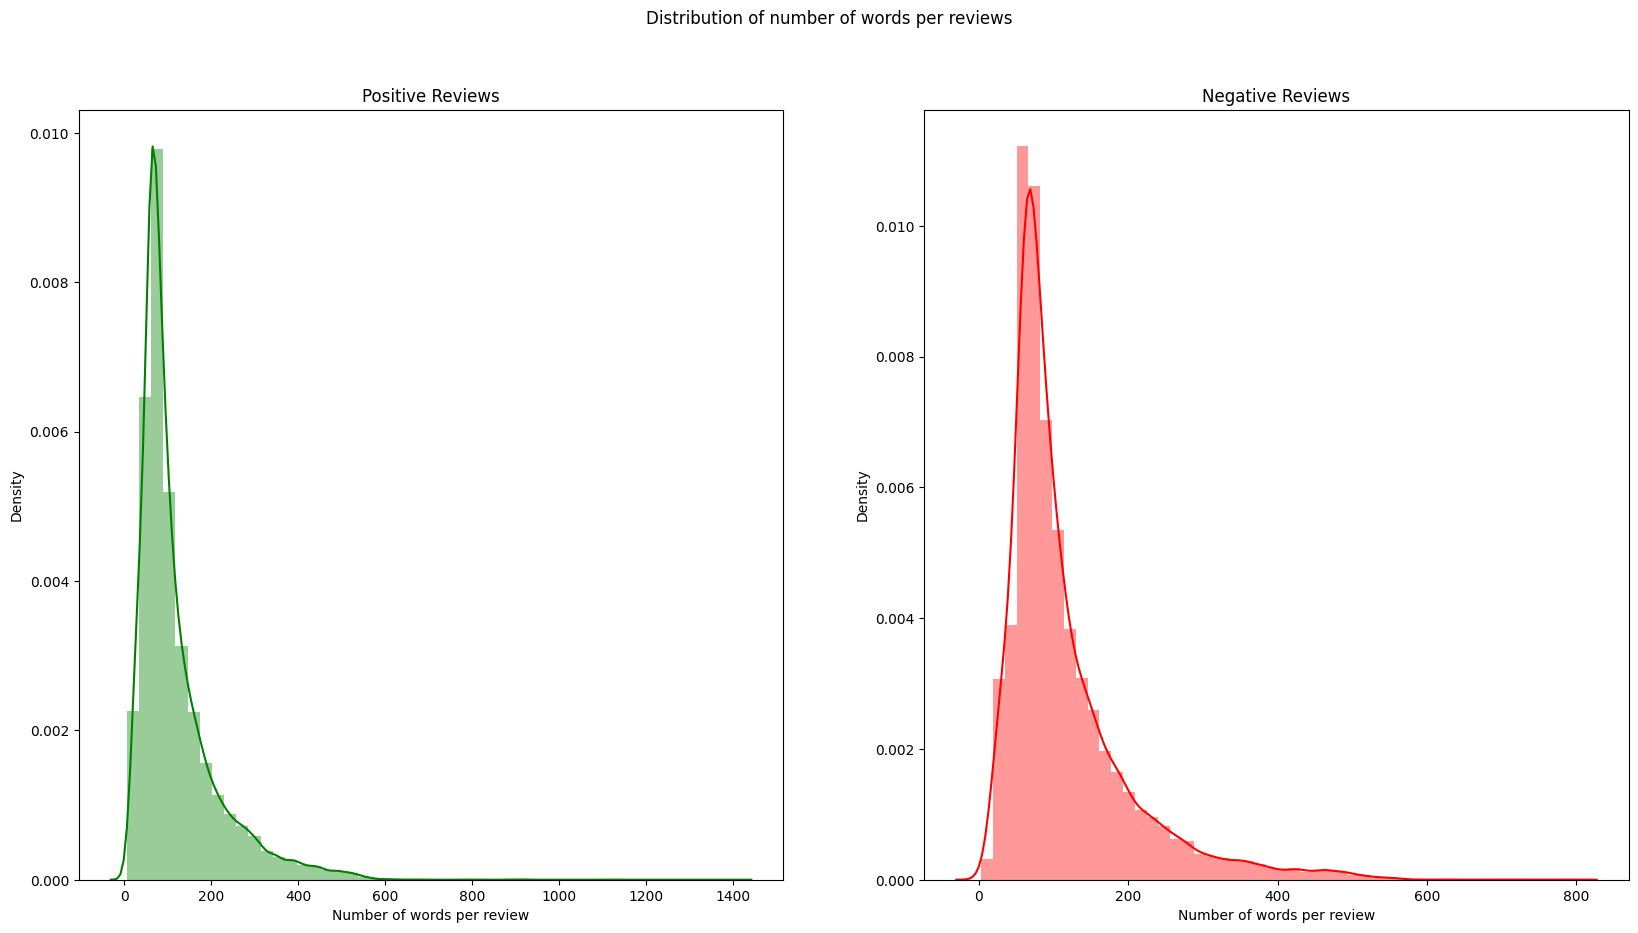

In [29]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of words per review')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of words per review')
fig.suptitle('Distribution of number of words per reviews')
plt.show()

C:\Users\vinhl\AppData\Local\Temp\ipykernel_11172\3098931170.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
C:\Users\vinhl\AppData\Local\Temp\ipykernel_11172\3098931170.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda 

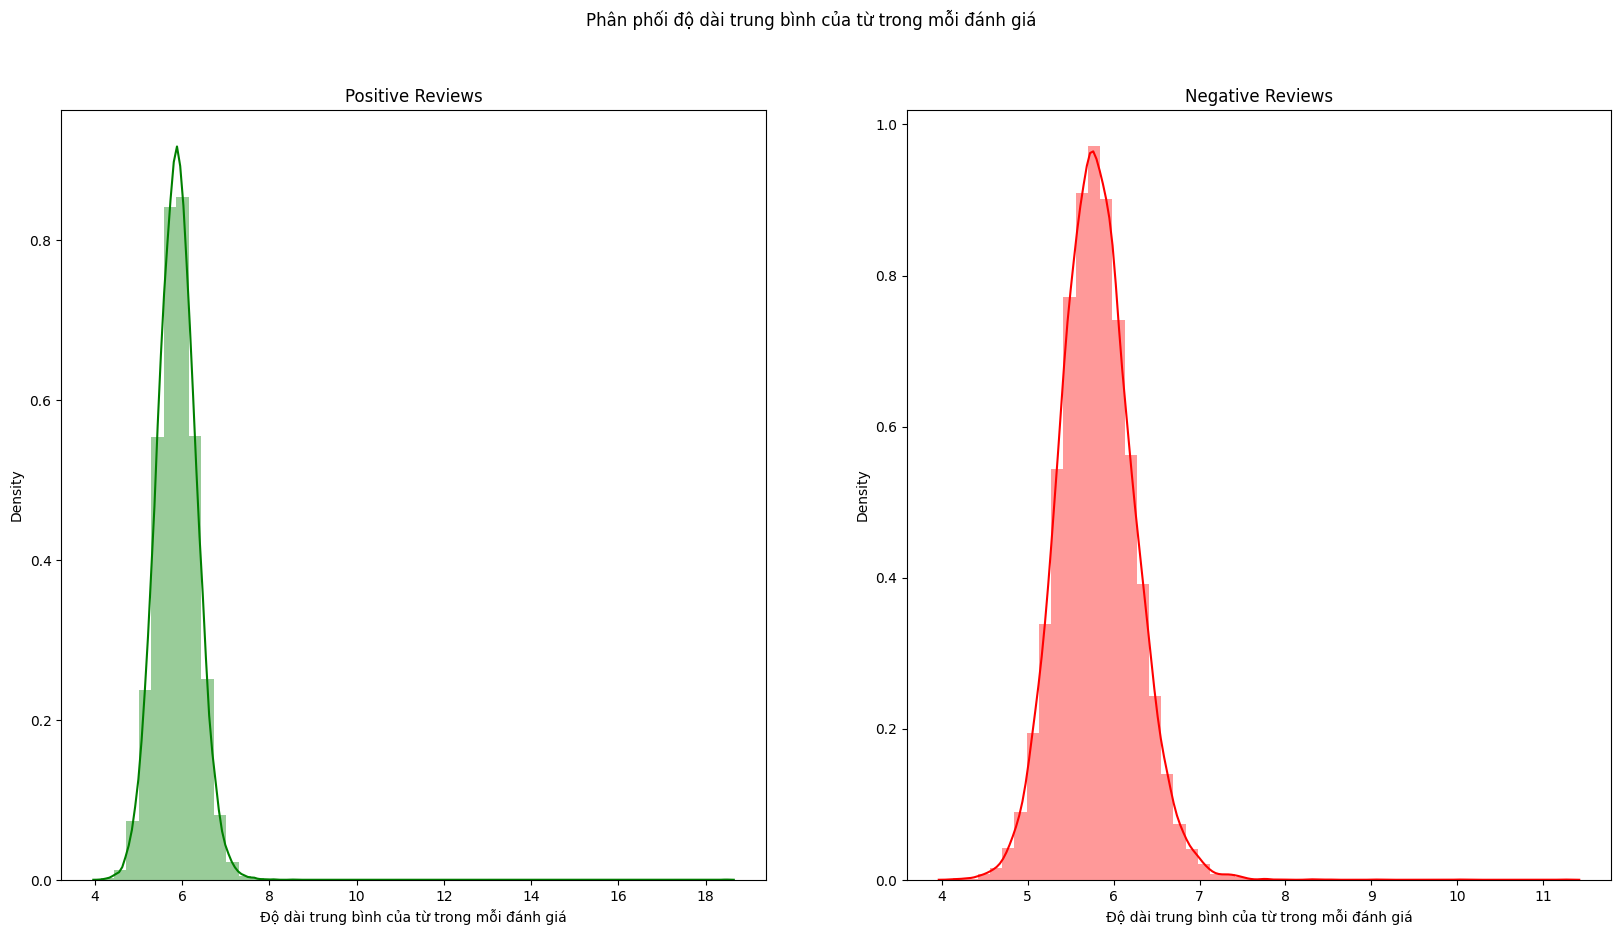

In [30]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Độ dài trung bình của từ trong mỗi đánh giá')
word = negative_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Độ dài trung bình của từ trong mỗi đánh giá')
fig.suptitle('Phân phối độ dài trung bình của từ trong mỗi đánh giá')
plt.show()

In [31]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.review)
corpus[:5]

['one', 'reviewer', 'mentioned', 'watching', 'oz']

In [32]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

corpus  countv
0      movie  100605
1       film   91130
2        one   53525
3       like   39746
4       time   30091
5      would   30037
6       good   28905
7  character   27801
8      story   24600
9       even   24440

In [33]:
most_common = most_common.sort_values('countv')

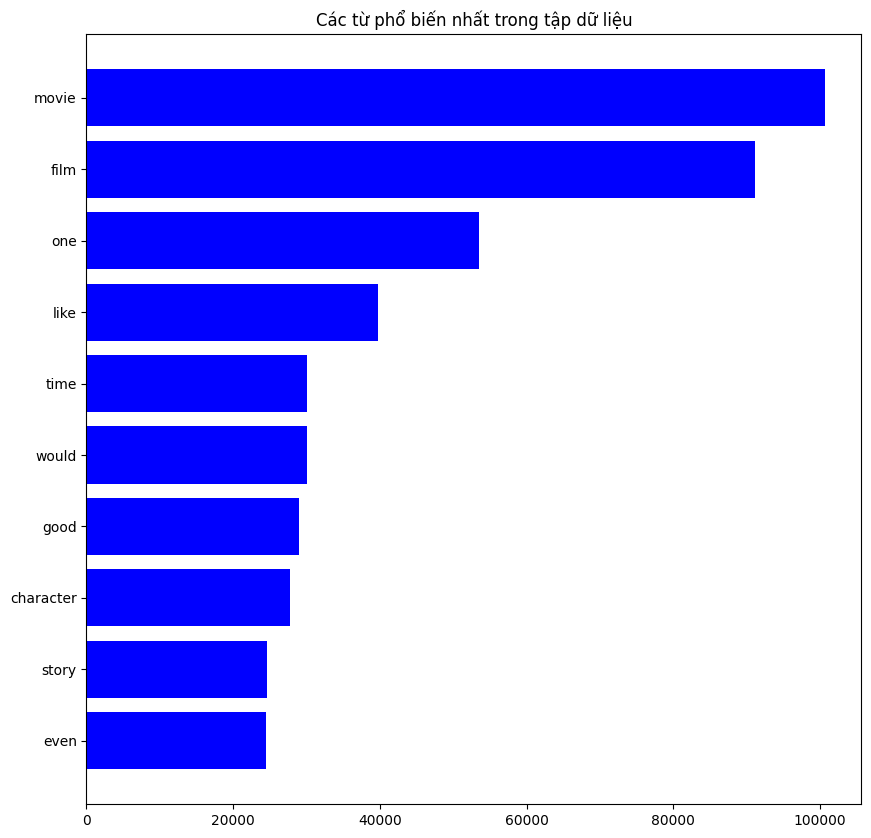

In [34]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Các từ phổ biến nhất trong tập dữ liệu')
plt.show()


In [35]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #ma trận thưa of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #tổng số từ
    sum_words = np.array(sum_words)[0].tolist() #chuyển sang list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency
    return words_freq[:n]

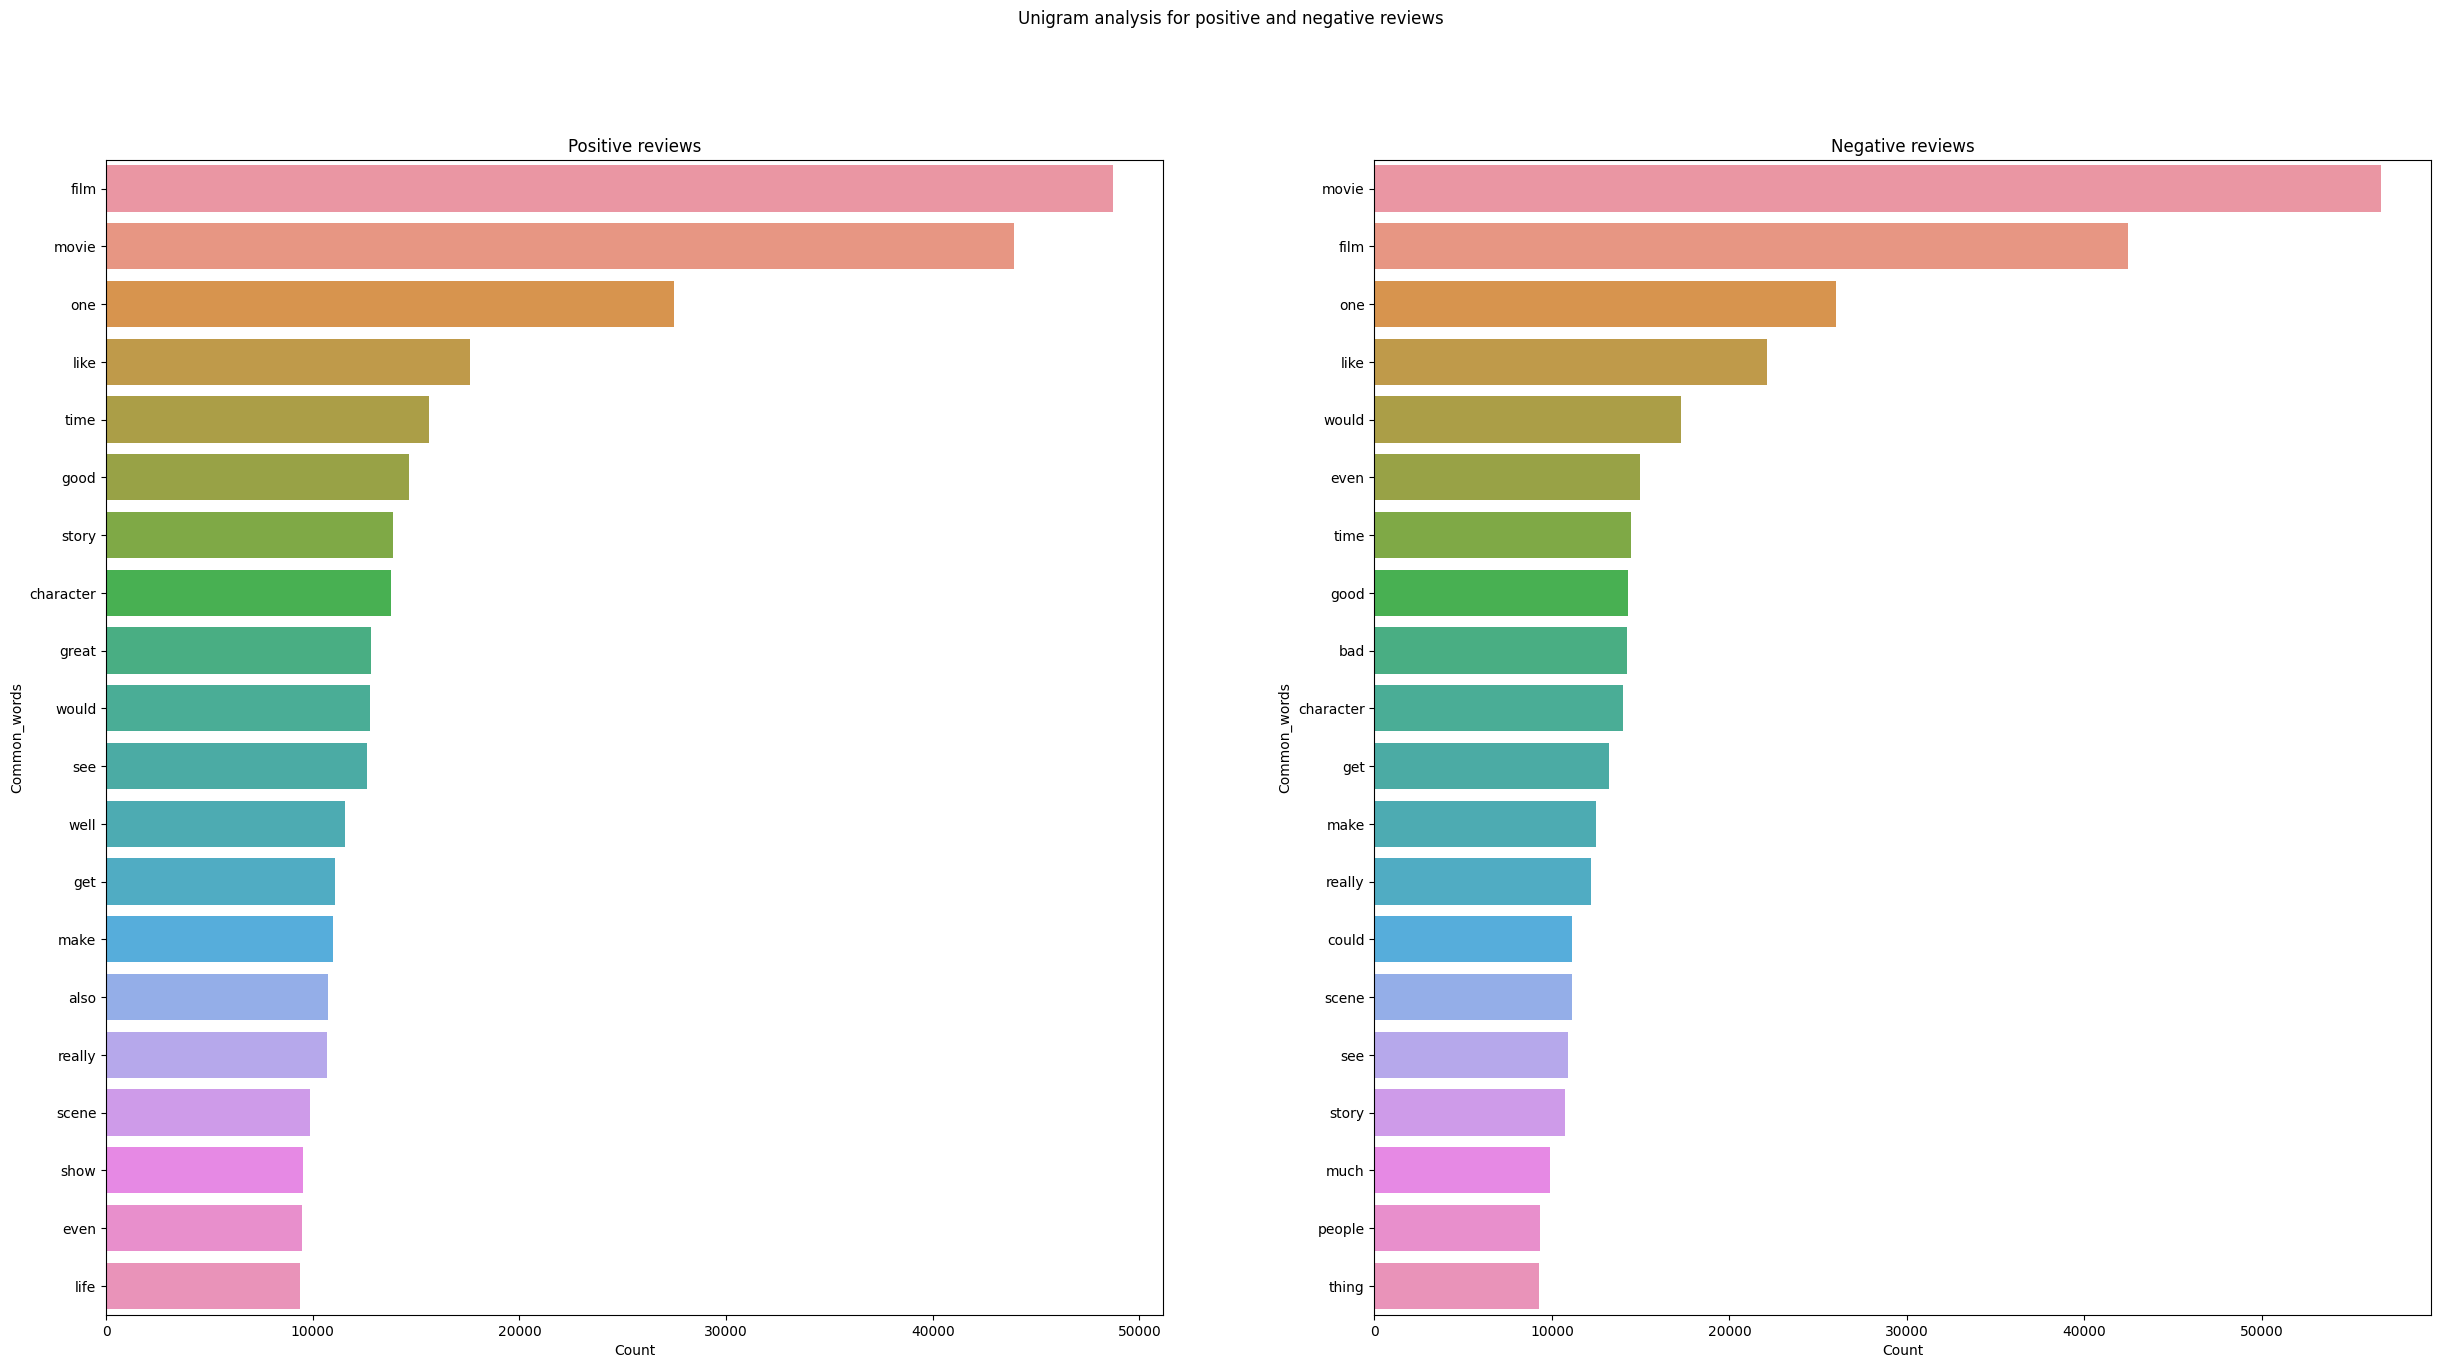

In [36]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Unigram analysis for positive and negative reviews')
plt.show()


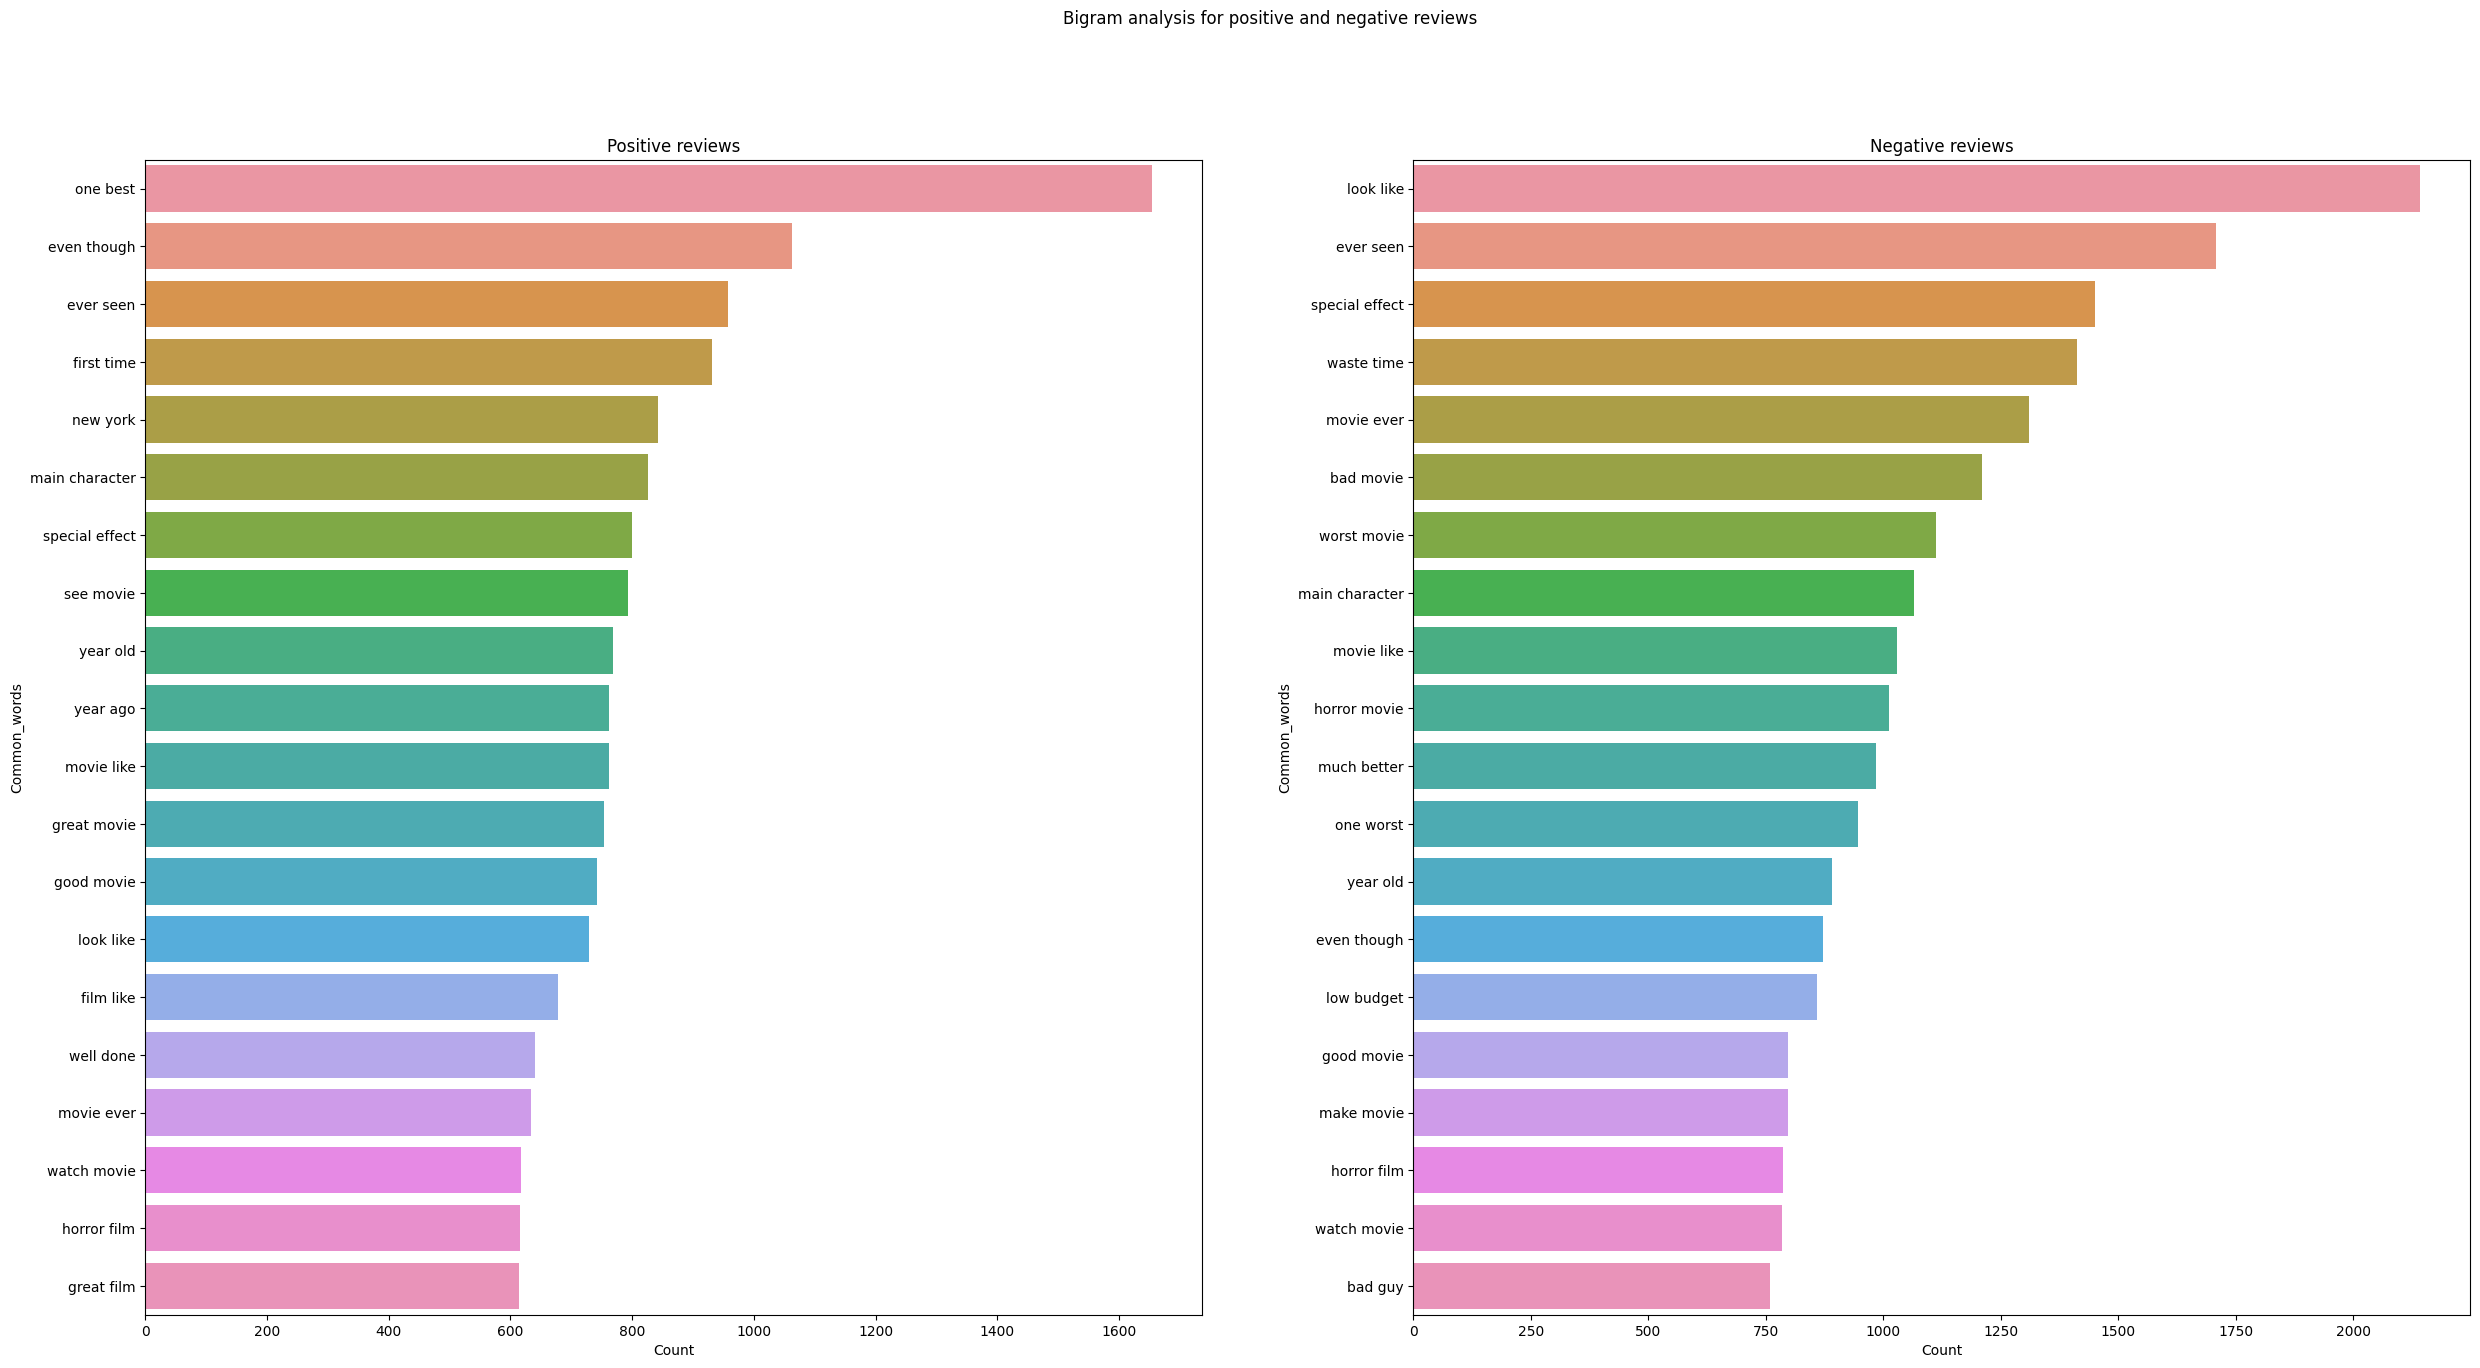

In [37]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
bi_positive = get_ngrams(positive_data,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
bi_negative = get_ngrams(negative_data,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Bigram analysis for positive and negative reviews')
plt.show()

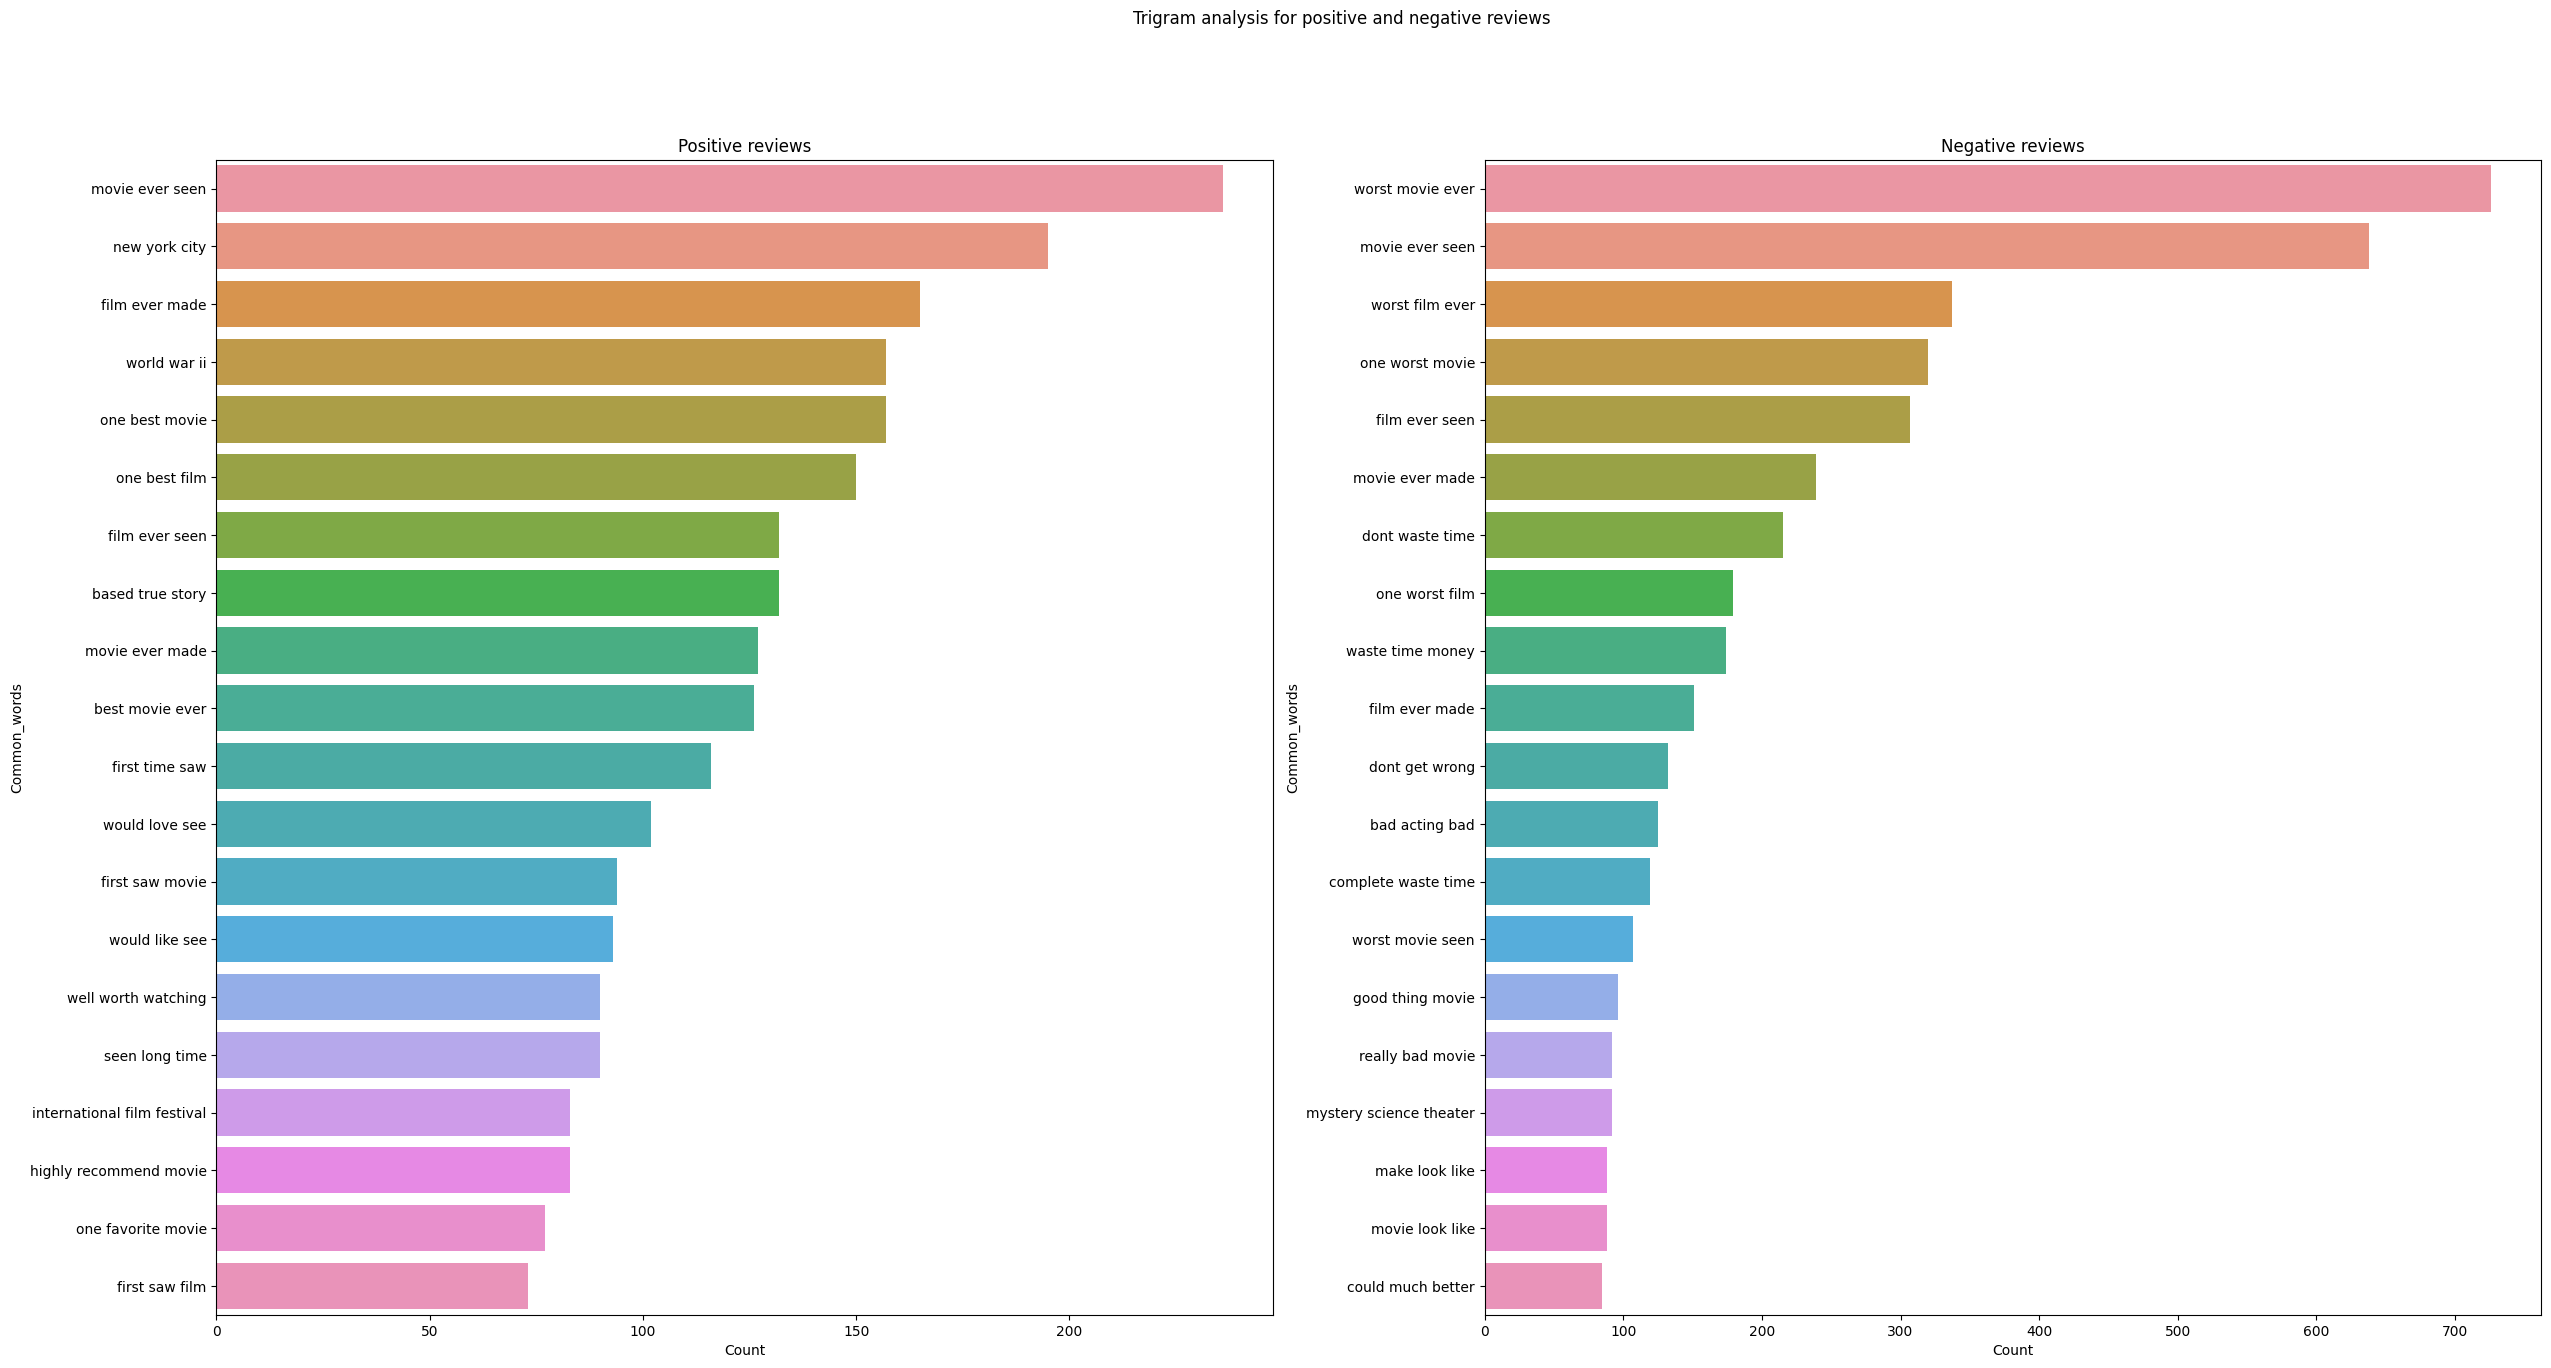

In [38]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
tri_positive = get_ngrams(positive_data,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
tri_negative = get_ngrams(negative_data,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Trigram analysis for positive and negative reviews')
plt.show()

# **4. Predictive Modelling using Machine Learning**

In [39]:
#splitting into train and test
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [40]:
#Vectorizing data

tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

In [41]:
pip install -U scikit-learn


Note: you may need to restart the kernel to use updated packages.


### Logistic Regression

Logistic Regression Accuracy: 89.09%


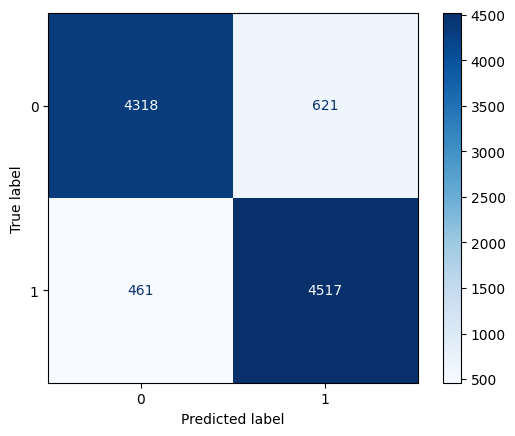

In [42]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Huấn luyện mô hình Logistic Regression
lr = LogisticRegression()
lr.fit(Xtrain_tfidf, ytrain)

# Dự đoán trên tập dữ liệu kiểm tra
p1 = lr.predict(Xtest_tfidf)

# Tính độ chính xác
s1 = accuracy_score(ytest, p1)
print("Logistic Regression Accuracy:", "{:.2f}%".format(100 * s1))

# Tạo confusion matrix
cm = confusion_matrix(ytest, p1)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()


In [43]:
x = "the movie so good"
x = clean_text(x)
x = tfidf_vect.transform([x])
p = lr.predict(x)
if p == 0:
    print("Tiêu cực")
else:
    print("Tích cực")

Tích cực


### Multinomial Naive Bayes

Multinomial Naive Bayes Classifier Accuracy: 86.79%


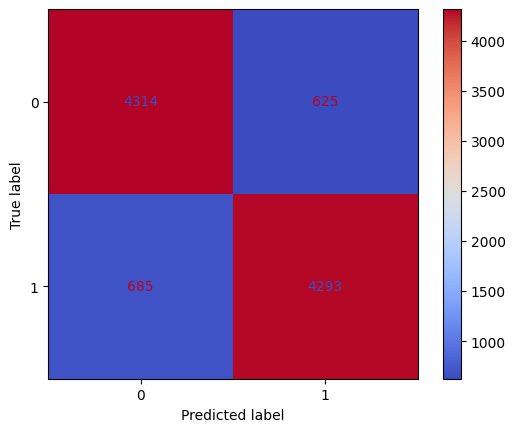

In [44]:
# Huấn luyện mô hình Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(Xtrain_tfidf, ytrain)

# Dự đoán trên tập dữ liệu kiểm tra
p2 = mnb.predict(Xtest_tfidf)

# Tính độ chính xác
s2 = accuracy_score(ytest, p2)
print("Multinomial Naive Bayes Classifier Accuracy:", "{:.2f}%".format(100 * s2))

# Tạo confusion matrix
cm = confusion_matrix(ytest, p2)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='coolwarm')
plt.grid(False)
plt.show()


### Linear SVM

Linear Support Vector Classifier Accuracy: 89.57%


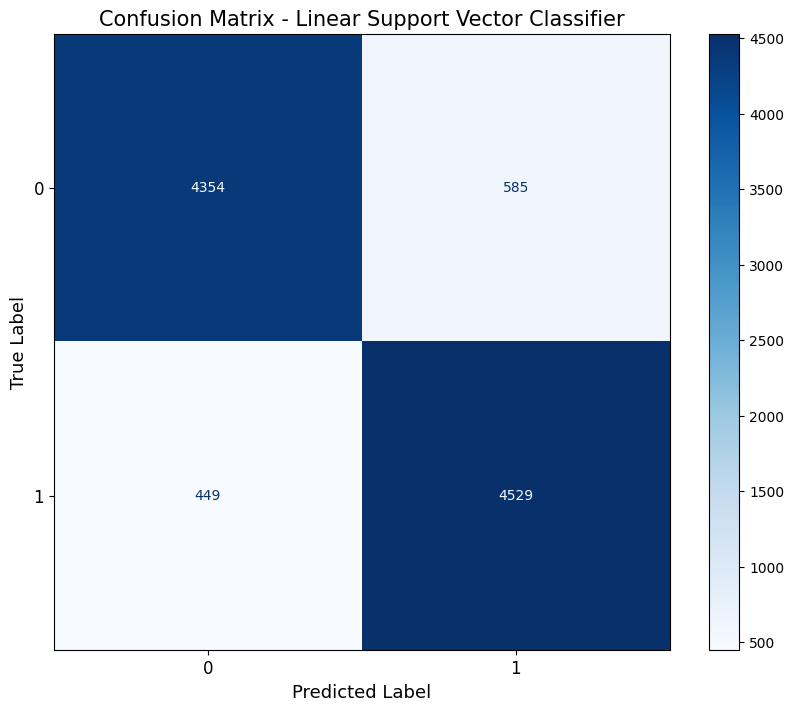

In [45]:
# Huấn luyện mô hình Linear Support Vector Classifier
linear_svc = LinearSVC(penalty='l2', loss='hinge')
linear_svc.fit(Xtrain_tfidf, ytrain)

# Dự đoán trên tập dữ liệu kiểm tra
p3 = linear_svc.predict(Xtest_tfidf)

# Tính độ chính xác
s3 = accuracy_score(ytest, p3)
print("Linear Support Vector Classifier Accuracy:", "{:.2f}%".format(100 * s3))

# Tạo confusion matrix
cm = confusion_matrix(ytest, p3)

# Tùy chỉnh màu sắc
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.color_palette("Blues", as_cmap=True)

# Hiển thị confusion matrix với tùy chỉnh màu sắc
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap, ax=ax, values_format='d')
plt.title('Confusion Matrix - Linear Support Vector Classifier', fontsize=15)
plt.grid(False)

# Tùy chỉnh thêm nếu cần
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.show()


### XGboost

XGBoost Accuracy: 84.55%


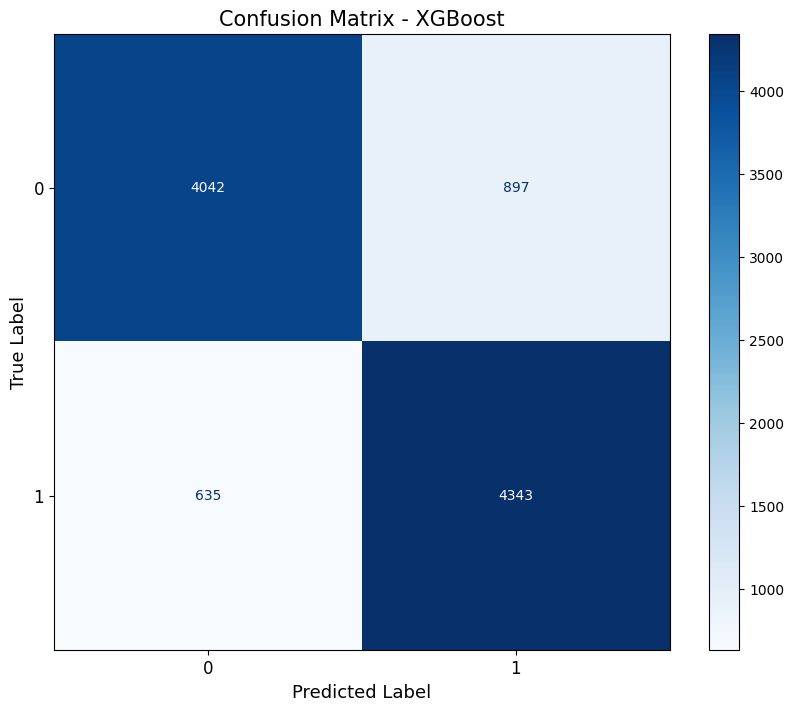

In [46]:
# Huấn luyện mô hình XGBoost
xgbo = XGBClassifier()
xgbo.fit(Xtrain_tfidf, ytrain)

# Dự đoán trên tập dữ liệu kiểm tra
p4 = xgbo.predict(Xtest_tfidf)

# Tính độ chính xác
s4 = accuracy_score(ytest, p4)
print("XGBoost Accuracy:", "{:.2f}%".format(100 * s4))

# Tạo confusion matrix
cm = confusion_matrix(ytest, p4)

# Tùy chỉnh màu sắc
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.color_palette("Blues", as_cmap=True)

# Hiển thị confusion matrix với tùy chỉnh màu sắc
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap, ax=ax, values_format='d')
plt.title('Confusion Matrix - XGBoost', fontsize=15)
plt.grid(False)

# Tùy chỉnh thêm nếu cần
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.show()

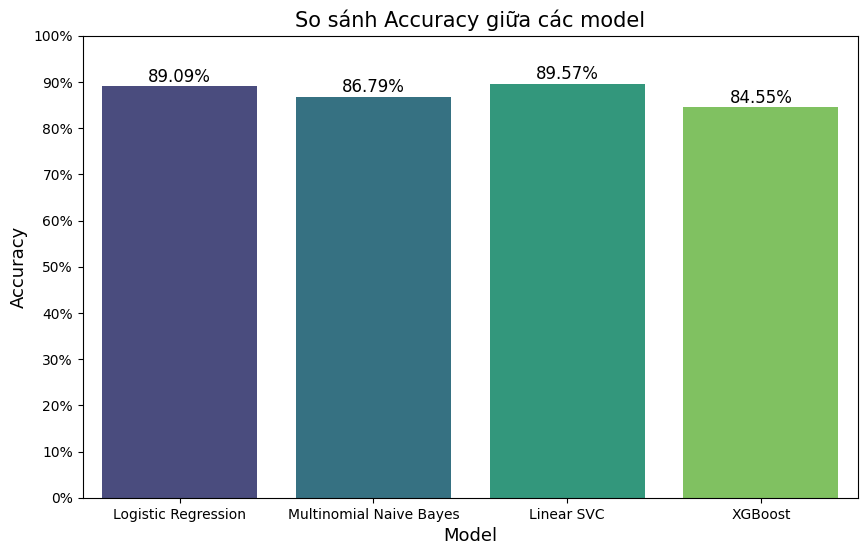

In [47]:
# Tạo danh sách các tên mô hình và độ chính xác tương ứng
models = ['Logistic Regression', 'Multinomial Naive Bayes', 'Linear SVC', 'XGBoost']
accuracies = [s1, s2, s3, s4]

# Vẽ biểu đồ cột so sánh hiệu suất các mô hình
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.xlabel('Model', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.title('So sánh Accuracy giữa các model', fontsize=15)
plt.ylim(0, 1)
plt.yticks(ticks=[i * 0.1 for i in range(11)], labels=[f'{i * 10}%' for i in range(11)])
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', fontsize=12)

plt.show()